In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 #version control
!pip install wandb
!pip install torchinfo
# !wandb login()

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.7/214.7 kB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=1e2ae3021be93d7eb9c2394cfa1a12ca53521ab5443b7d959307d64f37e344c6
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


# Handling Imports

In [ ]:
import torch
import torch.nn as nn                           #imports the neural network module which contains the nn superclass
import torch.optim as optim                     #imports the optimization algorithms such as gradient descent, adam etc
import torch.nn.functional as F                 #has all the parameter-less functions, imports the activation functions(relu etc), but those can also be found in the nn package
from torch.utils.data import DataLoader         #this provides a dataset class for data representation and a dataloader for iterating over the data among other things.
import torchvision.datasets as datasets         #pytorch comes with datasets which can be imported through this
import torchvision.transforms as transforms     #has methods to perform data augmentation operations such as cropping, resizing, normalization etc.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from tqdm import tqdm
from torchinfo import summary
import torchsummary
import numpy as np

# Creating a CNN

## ResidualBlock and BottleneckBlock CNNs

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, in_out_channels, kernel_size, stride, padding):
    super().__init__()
    self.conv1 = nn.Conv2d(in_out_channels, in_out_channels, kernel_size, stride, padding)
    self.bn1 = nn.BatchNorm2d(in_out_channels)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_out_channels, in_out_channels, kernel_size, stride, padding)
    self.bn2 = nn.BatchNorm2d(in_out_channels)
    self.relu2 = nn.ReLU()

  def forward(self, x):
    residual = x
    x = self.bn1(self.conv1(x))
    x = self.relu1(x)
    x = self.bn2(self.conv2(x))
    x = x + residual     # skip connection
    x = self.relu2(x)
    return x


class BottleneckBlock(nn.Module):
  def __init__(self, in_out_channels, kernel_size, stride, padding, reduction_ratio):
    super().__init__()
    self.conv1 = nn.Conv2d(in_out_channels, in_out_channels//reduction_ratio, 1, 1, 0)
    self.bn1 = nn.BatchNorm2d(in_out_channels//reduction_ratio)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_out_channels//reduction_ratio, in_out_channels//reduction_ratio, 3, 1, 0)
    self.bn2 = nn.BatchNorm2d(in_out_channels//reduction_ratio)
    self.relu2 = nn.ReLU()
    self.conv3 = nn.Conv2d(in_out_channels//reduction_ratio, in_out_channels, 1, 1, 0)
    self.bn3 = nn.BatchNorm2d(in_out_channels)
    self.relu3 = nn.ReLU()

  def forward(self, x):
    residual = x
    x = self.relu1(self.bn1(self.conv1(x)))
    x = self.relu2(self.bn2(self.conv2(x)))
    x = self.bn3(self.conv3(x))
    x = x + residual
    x = self.relu3(x)
    return x

class MaaChodCNN(nn.Module):
  def __init__(self, in_channels=1, num_classes=10):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=7, stride=1, padding=3)
    self.pool1 = nn.MaxPool2d((2,2), (2, 2))
    self.residualblock1 = ResidualBlock(16, 3, 1, 1)
    self.residualblock2 = ResidualBlock(16, 3, 1, 1)
    self.pool2 = nn.MaxPool2d((2, 2), (2, 2))
    self.flatten = nn.Flatten()
    self.fc = nn.Linear(16*7*7, num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.residualblock1(x)
    x = self.residualblock2(x)
    x = self.pool2(x)
    x = self.flatten(x)
    x = self.fc(x)
    return x


model = MaaChodCNN(1, 10).to(device)
summary(model, (64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MaaChodCNN                               [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 28, 28]          800
├─MaxPool2d: 1-2                         [64, 16, 14, 14]          --
├─ResidualBlock: 1-3                     [64, 16, 14, 14]          --
│    └─Conv2d: 2-1                       [64, 16, 14, 14]          2,320
│    └─BatchNorm2d: 2-2                  [64, 16, 14, 14]          32
│    └─ReLU: 2-3                         [64, 16, 14, 14]          --
│    └─Conv2d: 2-4                       [64, 16, 14, 14]          2,320
│    └─BatchNorm2d: 2-5                  [64, 16, 14, 14]          32
│    └─ReLU: 2-6                         [64, 16, 14, 14]          --
├─ResidualBlock: 1-4                     [64, 16, 14, 14]          --
│    └─Conv2d: 2-7                       [64, 16, 14, 14]          2,320
│    └─BatchNorm2d: 2-8                  [64, 16, 14, 14]          32
│    

## Normal CNN

In [ ]:
class CNN(nn.Module):
  def __init__(self, in_channels=1, num_classes=10):                                                                       #constructor method which creates the object of the written class
    super(CNN, self).__init__()                                                                                          #super method which inherits the methods from the parent nn.Module class
    self.layers = nn.Sequential(
      nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=7, stride=1, padding=3),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Flatten(),
      nn.Linear(32*7*7, num_classes)
    )

  def forward(self, x):
    x = self.layers(x)
    return x


model = CNN(1, 10)

# summary(model, (1, 28, 28))
summary(model, input_size=(64, 1, 28, 28))

# Set Device

In [ ]:
 #sets the device to cuda or cpu depending on the avaialability

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if the model has any errors in the structure

In [ ]:
model = model.to(device)

# Hyperparameters

In [ ]:
in_channels = 1
batch_size = 64
learning_rate = 10e-4

#output labels
num_classes = 10

#number of epochs the model is training for
num_epochs = 20

# Transforms

In [ ]:
train_transforms = transforms.Compose([ transforms.ToTensor() , transforms.Normalize((0.1307), (0.3081)), transforms.RandomRotation(5), transforms.Resize((30,30)), transforms.CenterCrop((28,28))])

# Load Data

In [ ]:
#loading the dataset from pytorch

train_dataset = datasets.MNIST(root='dataset/', train=True, transform=train_transforms, download=True) #downloads the MNIST dataset if it isn't already installed
val_dataset = datasets.MNIST(root='dataset/', train=False, transform=train_transforms, download=True)


# Initialzing Data Loaders

In [ ]:
#initialzing the data loaders for train,val and test sets respectively

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

# Initialize Network

# Loss and Optimizer

In [ ]:
#choosing the loss function and optimizing algorithm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network

In [ ]:
def check_accuracy(model, loader):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

In [ ]:
def train(epoch, train_losses, train_accuracies):

    train_loss=0
    loop = tqdm(train_loader)

    for batch_idx, (data, targets) in enumerate(loop):

        #get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        #forward
        scores = model(data)
        loss = criterion(scores, targets)

        #backward
        optimizer.zero_grad() #so it doesnt store gradients from prev back props
        loss.backward()

        #gradient descent or adam step
        optimizer.step()

        #accumulating loss over an epoch
        train_loss += loss.item()

        loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
        loop.set_postfix(loss=loss.item(), acc=torch.rand(1).item())

    train_loss = train_loss/len(train_loader)
    train_losses.append(train_loss)

    train_accuracy = check_accuracy(model, train_loader)
    train_accuracies.append(train_accuracy)

    return train_loss, train_accuracy

# Validation Loss


In [ ]:
# calculating the loss for val_set

def val(epoch, val_losses, val_accuracies):

  val_loss=0

  with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(val_loader): # dividing into batches is popssibly unecessary (will check later)

      #calling the model with the val data and calculating the loss
      scores = model(data)
      loss = criterion(scores, targets)

      #accumulating val loss over an epoch
      val_loss += loss.item()

  val_loss = val_loss/len(val_loader)
  val_losses.append(val_loss)

  val_accuracy = check_accuracy(model, val_loader)
  val_accuracies.append(val_accuracy)

  return val_loss, val_accuracy


# Training the model over epochs


In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [ ]:
#loops for 20 epochs (will add print statements)


for epoch in range(num_epochs):
    model.train()
    loss_train, acc_train = train(epoch, train_losses, train_accuracies)
    model.eval()
    loss_valid, acc_valid = val(epoch, val_losses, val_accuracies)

    # wandb.log({
    #     "Epoch": epoch,
    #     "Train Loss": loss_train,
    #     "Train Acc": acc_train,
    #     "Valid Loss": loss_valid,
    #     "Valid Acc": acc_valid})

    print(f'Epoch: {epoch}  Train Loss: {loss_train:.4f}  Train Acc: {acc_train:.4f}  Valid Loss: {loss_valid:.4f}  Valid Acc: {acc_valid:.4f}')


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Epoch [0/20]: 100%|██████████| 938/938 [02:10<00:00,  7.20it/s, acc=1, loss=0.285]


Epoch: 0  Train Loss: 0.1381  Train Acc: 0.9779  Valid Loss: 0.0613  Valid Acc: 0.9813


Epoch [1/20]: 100%|██████████| 938/938 [02:09<00:00,  7.23it/s, acc=0.214, loss=0.00603]


Epoch: 1  Train Loss: 0.0549  Train Acc: 0.9826  Valid Loss: 0.0596  Valid Acc: 0.9815


Epoch [2/20]: 100%|██████████| 938/938 [02:09<00:00,  7.23it/s, acc=0.738, loss=0.0155]


Epoch: 2  Train Loss: 0.0431  Train Acc: 0.9830  Valid Loss: 0.0558  Valid Acc: 0.9827


Epoch [3/20]: 100%|██████████| 938/938 [02:10<00:00,  7.20it/s, acc=0.703, loss=0.00217]


Epoch: 3  Train Loss: 0.0367  Train Acc: 0.9885  Valid Loss: 0.0441  Valid Acc: 0.9873


Epoch [4/20]:  80%|████████  | 753/938 [01:43<00:23,  7.80it/s, acc=0.913, loss=0.0727]

# Accuracy Check

# Checking the accuracy on training, validation and test sets


In [ ]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}") #highest was 99.66
print(f"Accuracy on validation set: {check_accuracy(val_loader, model)*100:.2f}")
# print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}") #highest was 98.68

Accuracy on training set: 99.63
Accuracy on validation set: 99.28


# Plotting the Train Loss and Validation loss vs number of epochs

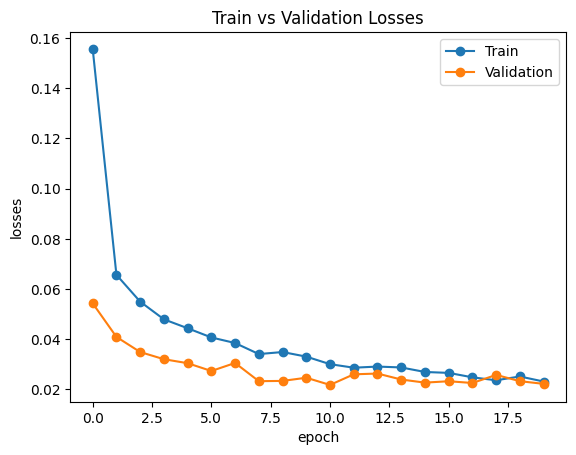

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_losses,'-o')
plt.plot(val_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Validation'])
plt.title('Train vs Validation Losses')

plt.show()

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(count_parameters(model))

20842
